In [1]:
import pymc3 as pm
import numpy as np
import theano
import matplotlib.pylab as plt

import seaborn as sns

In [2]:
# Generate data
ntrials = 1000
sig_mu_true = 0.5
mu_true = np.random.normal(0, sig_mu_true, size=ntrials)
X = np.arange(0, ntrials)
Y = mu_true + np.random.normal(0, 0.1, size=ntrials)

In [3]:
# Minibatch
ntrials_mb = 200
Y_mb = pm.Minibatch(Y, ntrials_mb)
X_mb = pm.Minibatch(X, ntrials_mb)

# Set up model
with pm.Model() as m:
    sig_mu = pm.HalfNormal('sig_mu', sd=2.)
    mu = pm.Normal('mu', 0, sd=sig_mu, shape=ntrials)
    Y_obs = pm.Normal('Y_obs', 
                      mu=mu[X_mb], 
                      sd=0.1, 
                      observed=Y_mb, 
                      total_size=ntrials)

# Use ADVI
with m:
    approx = pm.fit(40000, obj_n_mc=5)

Average Loss = 164.59: 100%|██████████| 40000/40000 [01:20<00:00, 498.26it/s]
Finished [100%]: Average Loss = 164.63


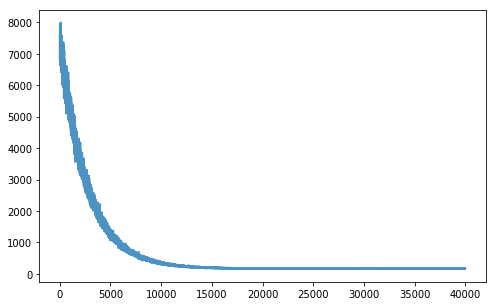

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(approx.hist, alpha=.8);

In [5]:
approx_val = approx.bij.rmap(approx.params[0].eval())

In [6]:
approx_val.keys()

dict_keys(['sig_mu_log__', 'mu'])

In [7]:
np.exp(approx_val['sig_mu_log__'])

0.5118672442725395

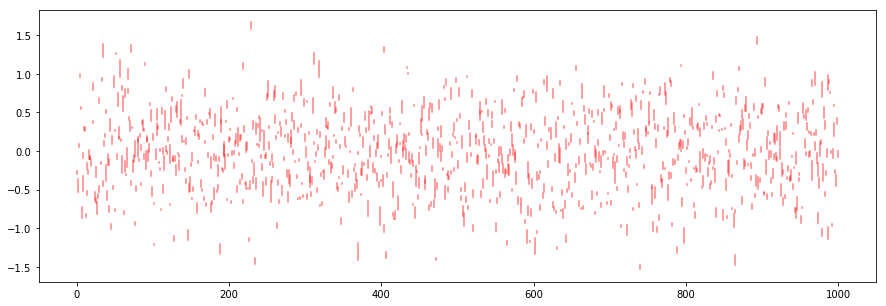

In [8]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(np.tile(np.arange(0, ntrials)[:, np.newaxis], 2).T,
        np.asarray([mu_true, approx_val['mu']]),
        color='r', alpha=.5);

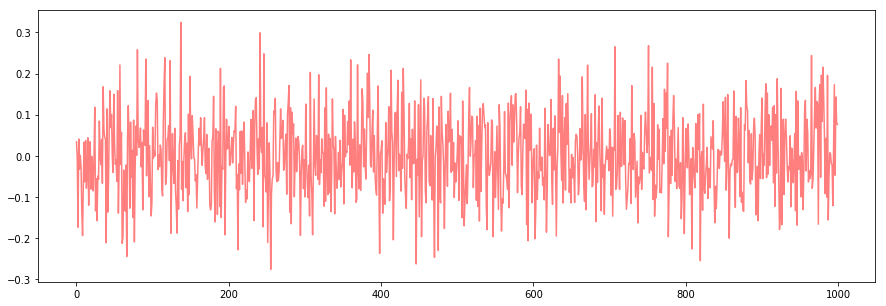

In [9]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(mu_true-approx_val['mu'],
        color='r', alpha=.5);

In [10]:
# Minibatch
Y_mb = pm.Minibatch(Y, ntrials_mb)
X_mb = pm.Minibatch(X, ntrials_mb)
Y_shared = theano.shared(Y)
X_shared = theano.shared(X)

# Set up model
with pm.Model() as m2:
    sig_mu = pm.HalfNormal('sig_mu', sd=2.)
    mu = pm.Normal('mu', 0, sd=sig_mu, shape=ntrials)
    Y_obs = pm.Normal('Y_obs', 
                      mu=mu[X_shared], 
                      sd=0.1, 
                      observed=Y_shared, 
                      total_size=ntrials)

# Use ADVI
with m2:
    approx = pm.fit(50000, 
                    obj_n_mc=5, 
                    more_replacements={X_shared: X_mb,
                                       Y_shared: Y_mb})

Average Loss = 198.54: 100%|██████████| 50000/50000 [01:23<00:00, 601.25it/s] 
Finished [100%]: Average Loss = 198.54


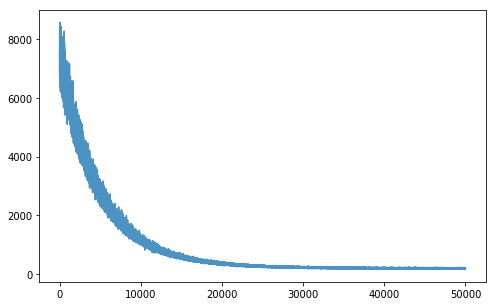

In [11]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(approx.hist, alpha=.8);

In [12]:
approx_val2 = approx.bij.rmap(approx.params[0].eval())

In [13]:
approx_val2.keys()

dict_keys(['sig_mu_log__', 'mu'])

In [14]:
np.exp(approx_val2['sig_mu_log__'])

0.49379245430753005

In [15]:
m2.logp(approx_val), m2.logp(approx_val2)

(array(612.16293421), array(550.33481613))

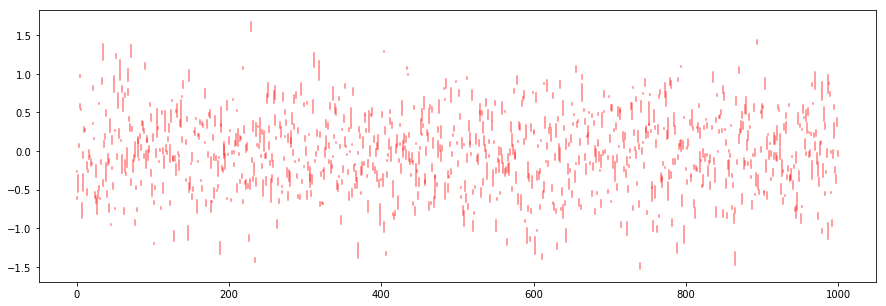

In [16]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(np.tile(np.arange(0, ntrials)[:, np.newaxis], 2).T,
        np.asarray([mu_true, approx_val2['mu']]),
        color='r', alpha=.5);

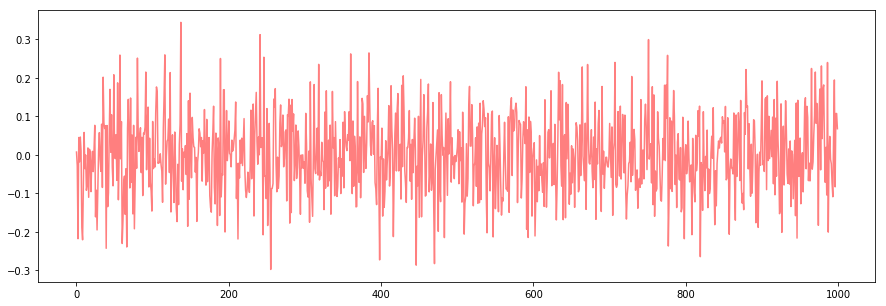

In [17]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(mu_true-approx_val2['mu'],
        color='r', alpha=.5);